# Markov model

## Google

In [19]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print
import datetime

<ipython-input-21-cfbf8721336b>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


            TEDRATE  T10Y2Y  T10Y3M       GOOG      sret
2004-08-20     0.28    1.78    2.75  53.952770  0.076433
2004-08-23     0.23    1.78    2.74  54.495735  0.010013
2004-08-24     0.24    1.78    2.74  52.239197 -0.042289
2004-08-25     0.25    1.75    2.72  52.802086  0.010718
2004-08-26     0.26    1.74    2.67  53.753517  0.017858


<AxesSubplot:>

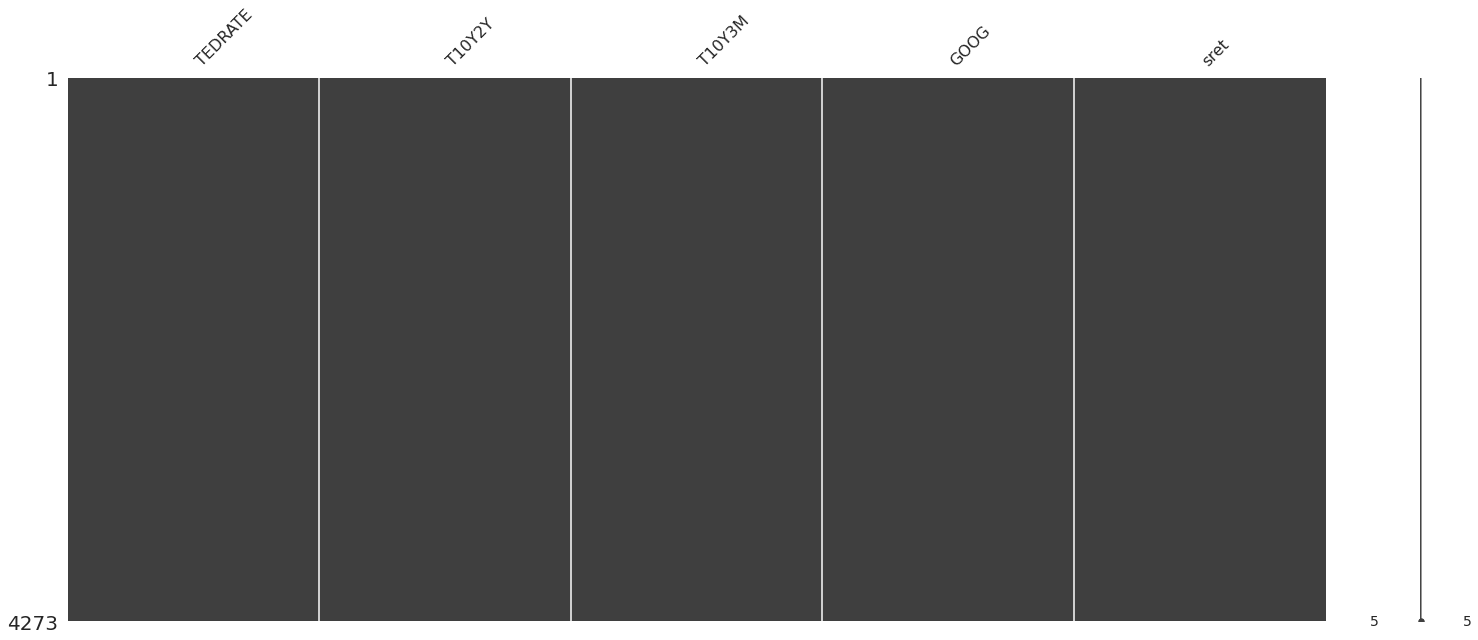

In [21]:
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2000-01-01')
end = pd.datetime.today()

mkt = 'GOOG'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

Means and vars of each hidden state
0th hidden state
mean =  [0.36858269 0.22824175 0.37124565 0.00063252]
var =  [2.21705342e-02 6.00619085e-02 3.20953138e-01 2.81538338e-04]

1th hidden state
mean =  [2.64232936e-01 1.63983468e+00 2.08255555e+00 9.67519722e-04]
var =  [1.24073162e-02 4.70338498e-01 6.14857235e-01 1.58789458e-04]

2th hidden state
mean =  [1.15084313e+00 1.37817721e+00 1.83002082e+00 2.51123522e-04]
var =  [0.52270993 0.38150874 0.84637247 0.00127313]



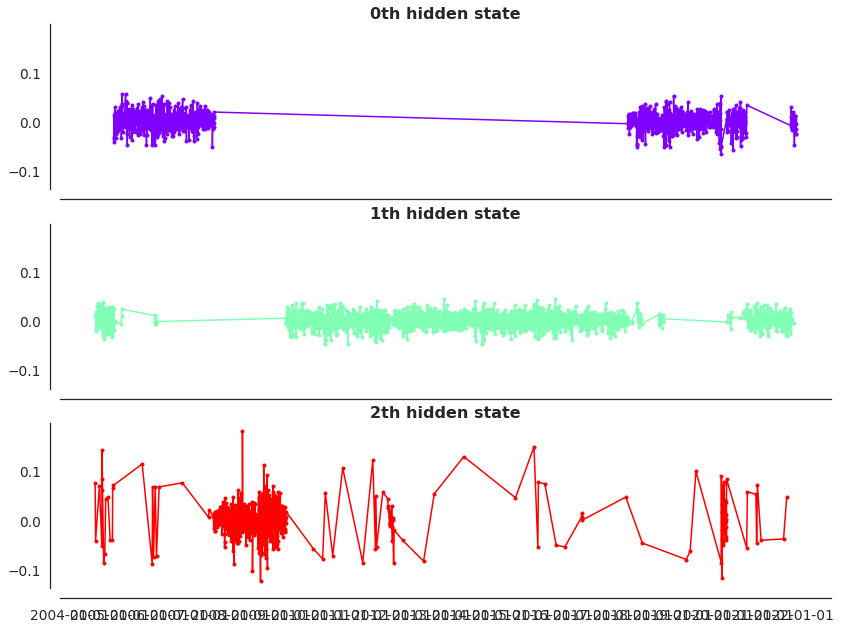

In [22]:
# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.loc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

        Date  states  TEDRATE  T10Y2Y  T10Y3M       GOOG      sret  mkt_cret
0 2004-08-20       2     0.28    1.78    2.75  53.952770  0.076433  0.076433
1 2004-08-23       1     0.23    1.78    2.74  54.495735  0.010013  0.086446
2 2004-08-24       2     0.24    1.78    2.74  52.239197 -0.042289  0.044157
3 2004-08-25       1     0.25    1.75    2.72  52.802086  0.010718  0.054875
4 2004-08-26       1     0.26    1.74    2.67  53.753517  0.017858  0.072733


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


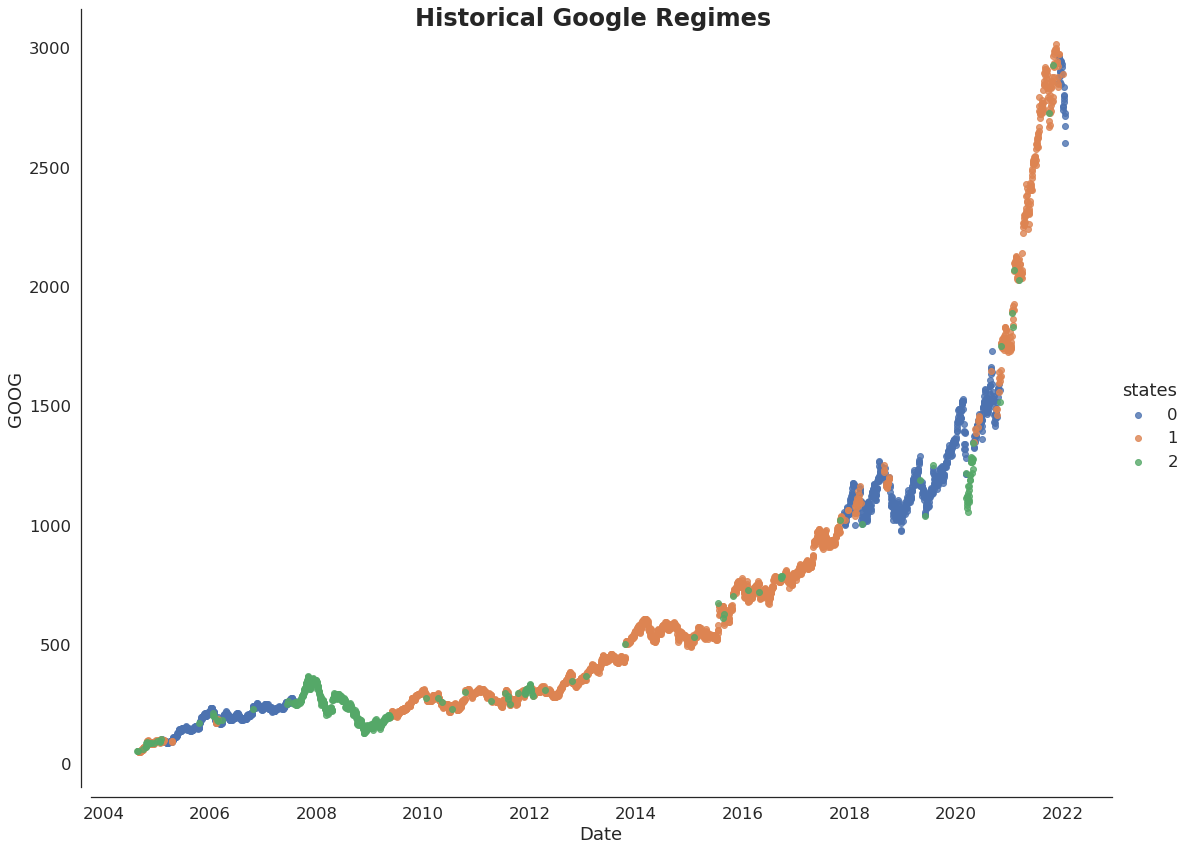

In [23]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical Google Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_GOOG Regimes.png')

Means and vars of each hidden state
0th hidden state
mean =  [0.36858269 0.22824175 0.37124565 0.00063252]
var =  [2.21705342e-02 6.00619085e-02 3.20953138e-01 2.81538338e-04]

1th hidden state
mean =  [2.64232936e-01 1.63983468e+00 2.08255555e+00 9.67519722e-04]
var =  [1.24073162e-02 4.70338498e-01 6.14857235e-01 1.58789458e-04]

2th hidden state
mean =  [1.15084313e+00 1.37817721e+00 1.83002082e+00 2.51123522e-04]
var =  [0.52270993 0.38150874 0.84637247 0.00127313]



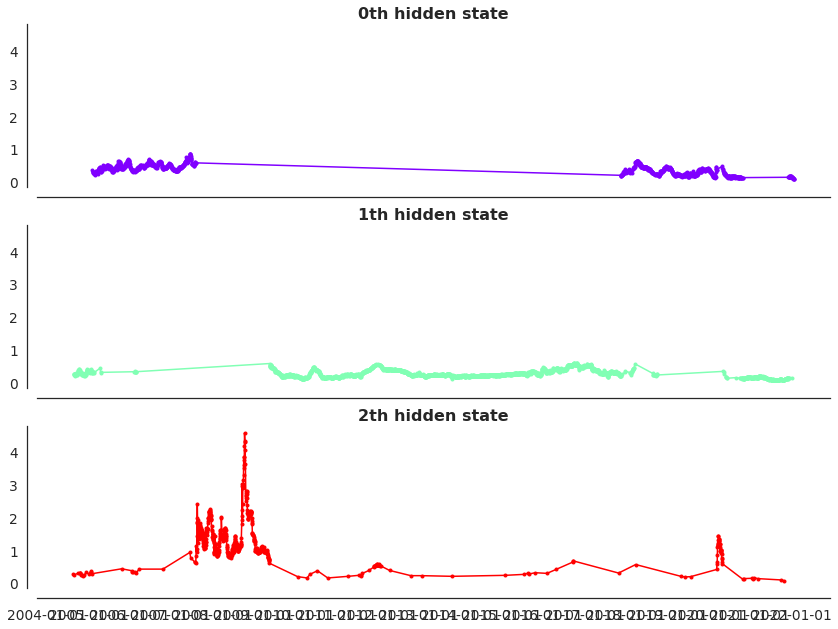

In [24]:
#TEDRATE  T10Y2Y  T10Y3M 
col = 'TEDRATE'
select = data.loc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

        Date  states  TEDRATE  T10Y2Y  T10Y3M       GOOG      sret  mkt_cret
0 2004-08-20       2     0.28    1.78    2.75  53.952770  0.076433      0.28
1 2004-08-23       1     0.23    1.78    2.74  54.495735  0.010013      0.51
2 2004-08-24       2     0.24    1.78    2.74  52.239197 -0.042289      0.75
3 2004-08-25       1     0.25    1.75    2.72  52.802086  0.010718      1.00
4 2004-08-26       1     0.26    1.74    2.67  53.753517  0.017858      1.26


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


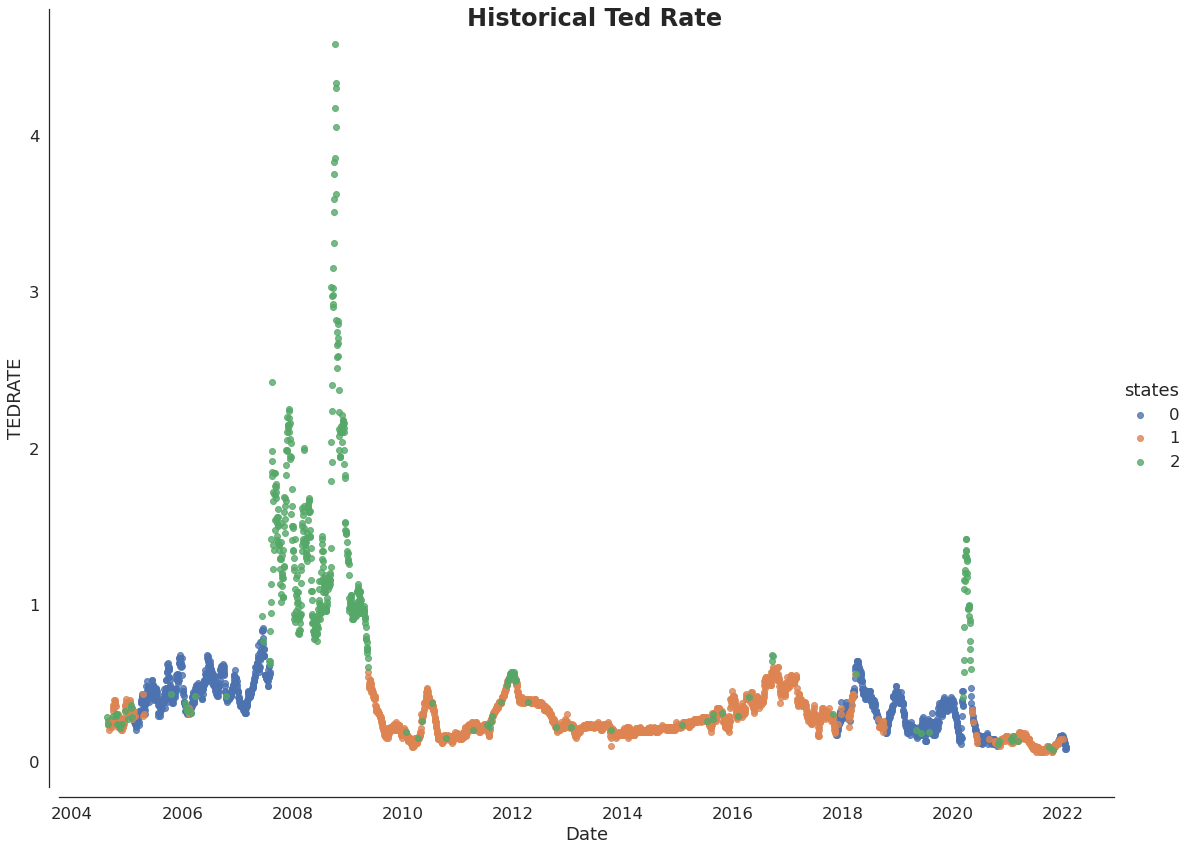

In [14]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.TEDRATE.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date','TEDRATE', alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical Ted Rate', fontsize=24, fontweight='demi')
fg.savefig('Ted Rate.png')

## Finding Equillibrium Matrix

In [26]:
start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

df = web.DataReader("GOOG", 'yahoo', start, end)

<ipython-input-26-a2edceaac1b3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


In [27]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086
...,...,...,...,...,...,...
2022-04-22,2509.040039,2382.810059,2500.000000,2392.280029,2317600.0,2392.280029
2022-04-25,2465.560059,2375.385010,2388.590088,2465.000000,1726100.0,2465.000000
2022-04-26,2455.000000,2383.237061,2455.000000,2390.120117,2469700.0,2390.120117


In [30]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))
df

,High,Low,Open,Close,Volume,Adj Close,state,priorstate
Date,,,,,,,,
2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655,Consolidation,NaN
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770,Upside,Consolidation
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735,Upside,Upside
2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197,Downside,Upside
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086,Upside,Downside
...,...,...,...,...,...,...,...,...
2022-04-22,2509.040039,2382.810059,2500.000000,2392.280029,2317600.0,2392.280029,Downside,Downside
2022-04-25,2465.560059,2375.385010,2388.590088,2465.000000,1726100.0,2465.000000,Upside,Downside
2022-04-26,2455.000000,2383.237061,2455.000000,2390.120117,2469700.0,2390.120117,Downside,Upside


In [31]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close,state,priorstate
Date,,,,,,,,
2022-04-22,2509.040039,2382.810059,2500.000000,2392.280029,2317600.0,2392.280029,Downside,Downside
2022-04-25,2465.560059,2375.385010,2388.590088,2465.000000,1726100.0,2465.000000,Upside,Downside
2022-04-26,2455.000000,2383.237061,2455.000000,2390.120117,2469700.0,2390.120117,Downside,Upside
2022-04-27,2350.000000,2262.485107,2287.459961,2300.409912,3111900.0,2300.409912,Downside,Downside
2022-04-28,2408.770020,2302.877686,2342.300049,2389.600098,1538414.0,2389.600098,Upside,Downside


In [32]:
df['priorstate']=df['state'].shift(1)
df.tail()

,High,Low,Open,Close,Volume,Adj Close,state,priorstate
Date,,,,,,,,
2022-04-22,2509.040039,2382.810059,2500.000000,2392.280029,2317600.0,2392.280029,Downside,Downside
2022-04-25,2465.560059,2375.385010,2388.590088,2465.000000,1726100.0,2465.000000,Upside,Downside
2022-04-26,2455.000000,2383.237061,2455.000000,2390.120117,2469700.0,2390.120117,Downside,Upside
2022-04-27,2350.000000,2262.485107,2287.459961,2300.409912,3111900.0,2300.409912,Downside,Downside
2022-04-28,2408.770020,2302.877686,2342.300049,2389.600098,1538414.0,2389.600098,Upside,Downside


# Coding Transition Matrix for Markov Chain Model

In [35]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state          Downside    Upside
priorstate                       
Consolidation  0.000000  1.000000
Downside       0.505286  0.494714
Upside         0.514430  0.485570


In [2]:
## Forecasting Futures Probabilities of States using Python

In [36]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state       Downside    Upside
priorstate                    
Downside    0.470894  0.529106
Upside      0.477147  0.522853


In [37]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_1

state,Downside,Upside
priorstate,,
Downside,0.474202,0.525798
Upside,0.474163,0.525837


In [38]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_1

state,Downside,Upside
priorstate,,
Downside,0.474182,0.525818
Upside,0.474182,0.525818


## Equilibrium Matrix using Python

In [39]:
## Equilibrium Matrix using Python

t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 9
state       Downside    Upside
priorstate                    
Downside    0.474182  0.525818
Upside      0.474182  0.525818


The equilibrium Matrix is a stationary state. So, As per the theory of the Markov Chain, This figure will stay the same for foreseeable data points

In [40]:
import datetime

In [41]:
##Random Walk

symbol = "GOOG"
days = 10000
end_date = datetime.datetime.now().strftime("%d-%b-%Y")
end_date = str(end_date)

start_date = (datetime.datetime.now()- datetime.timedelta(days=days)).strftime("%d-%b-%Y")
start_date = str(start_date)

#df=index_history("SPY",start_date,end_date)
df = web.DataReader("SPY", 'yahoo', start_date, end_date)

df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 11
state       Downside    Upside
priorstate                    
Downside    0.461052  0.538948
Upside      0.461052  0.538948
